In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

2024-06-27 08:05:05.518668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 08:05:05.518775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 08:05:05.648861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/ad-disease/train')):
    subfolder_path = os.path.join('/kaggle/input/ad-disease/train', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


,image,label
0,/kaggle/input/ad-disease/train/train/ModerateD...,ModerateDemented
1,/kaggle/input/ad-disease/train/train/ModerateD...,ModerateDemented
2,/kaggle/input/ad-disease/train/train/ModerateD...,ModerateDemented
3,/kaggle/input/ad-disease/train/train/ModerateD...,ModerateDemented
4,/kaggle/input/ad-disease/train/train/ModerateD...,ModerateDemented
...,...,...
5116,/kaggle/input/ad-disease/train/train/MildDemen...,MildDemented
5117,/kaggle/input/ad-disease/train/train/MildDemen...,MildDemented
5118,/kaggle/input/ad-disease/train/train/MildDemen...,MildDemented
5119,/kaggle/input/ad-disease/train/train/MildDemen...,MildDemented


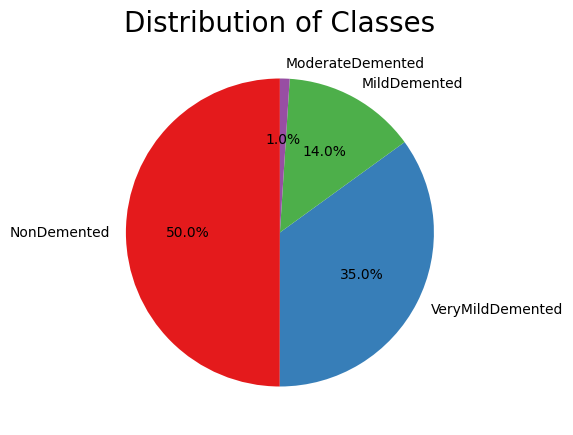

In [3]:
plt.figure(figsize=(5, 5))
class_counts = df['label'].value_counts()
labels = class_counts.index
sizes = class_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set1'))
plt.title('Distribution of Classes', fontsize=20)
plt.show()

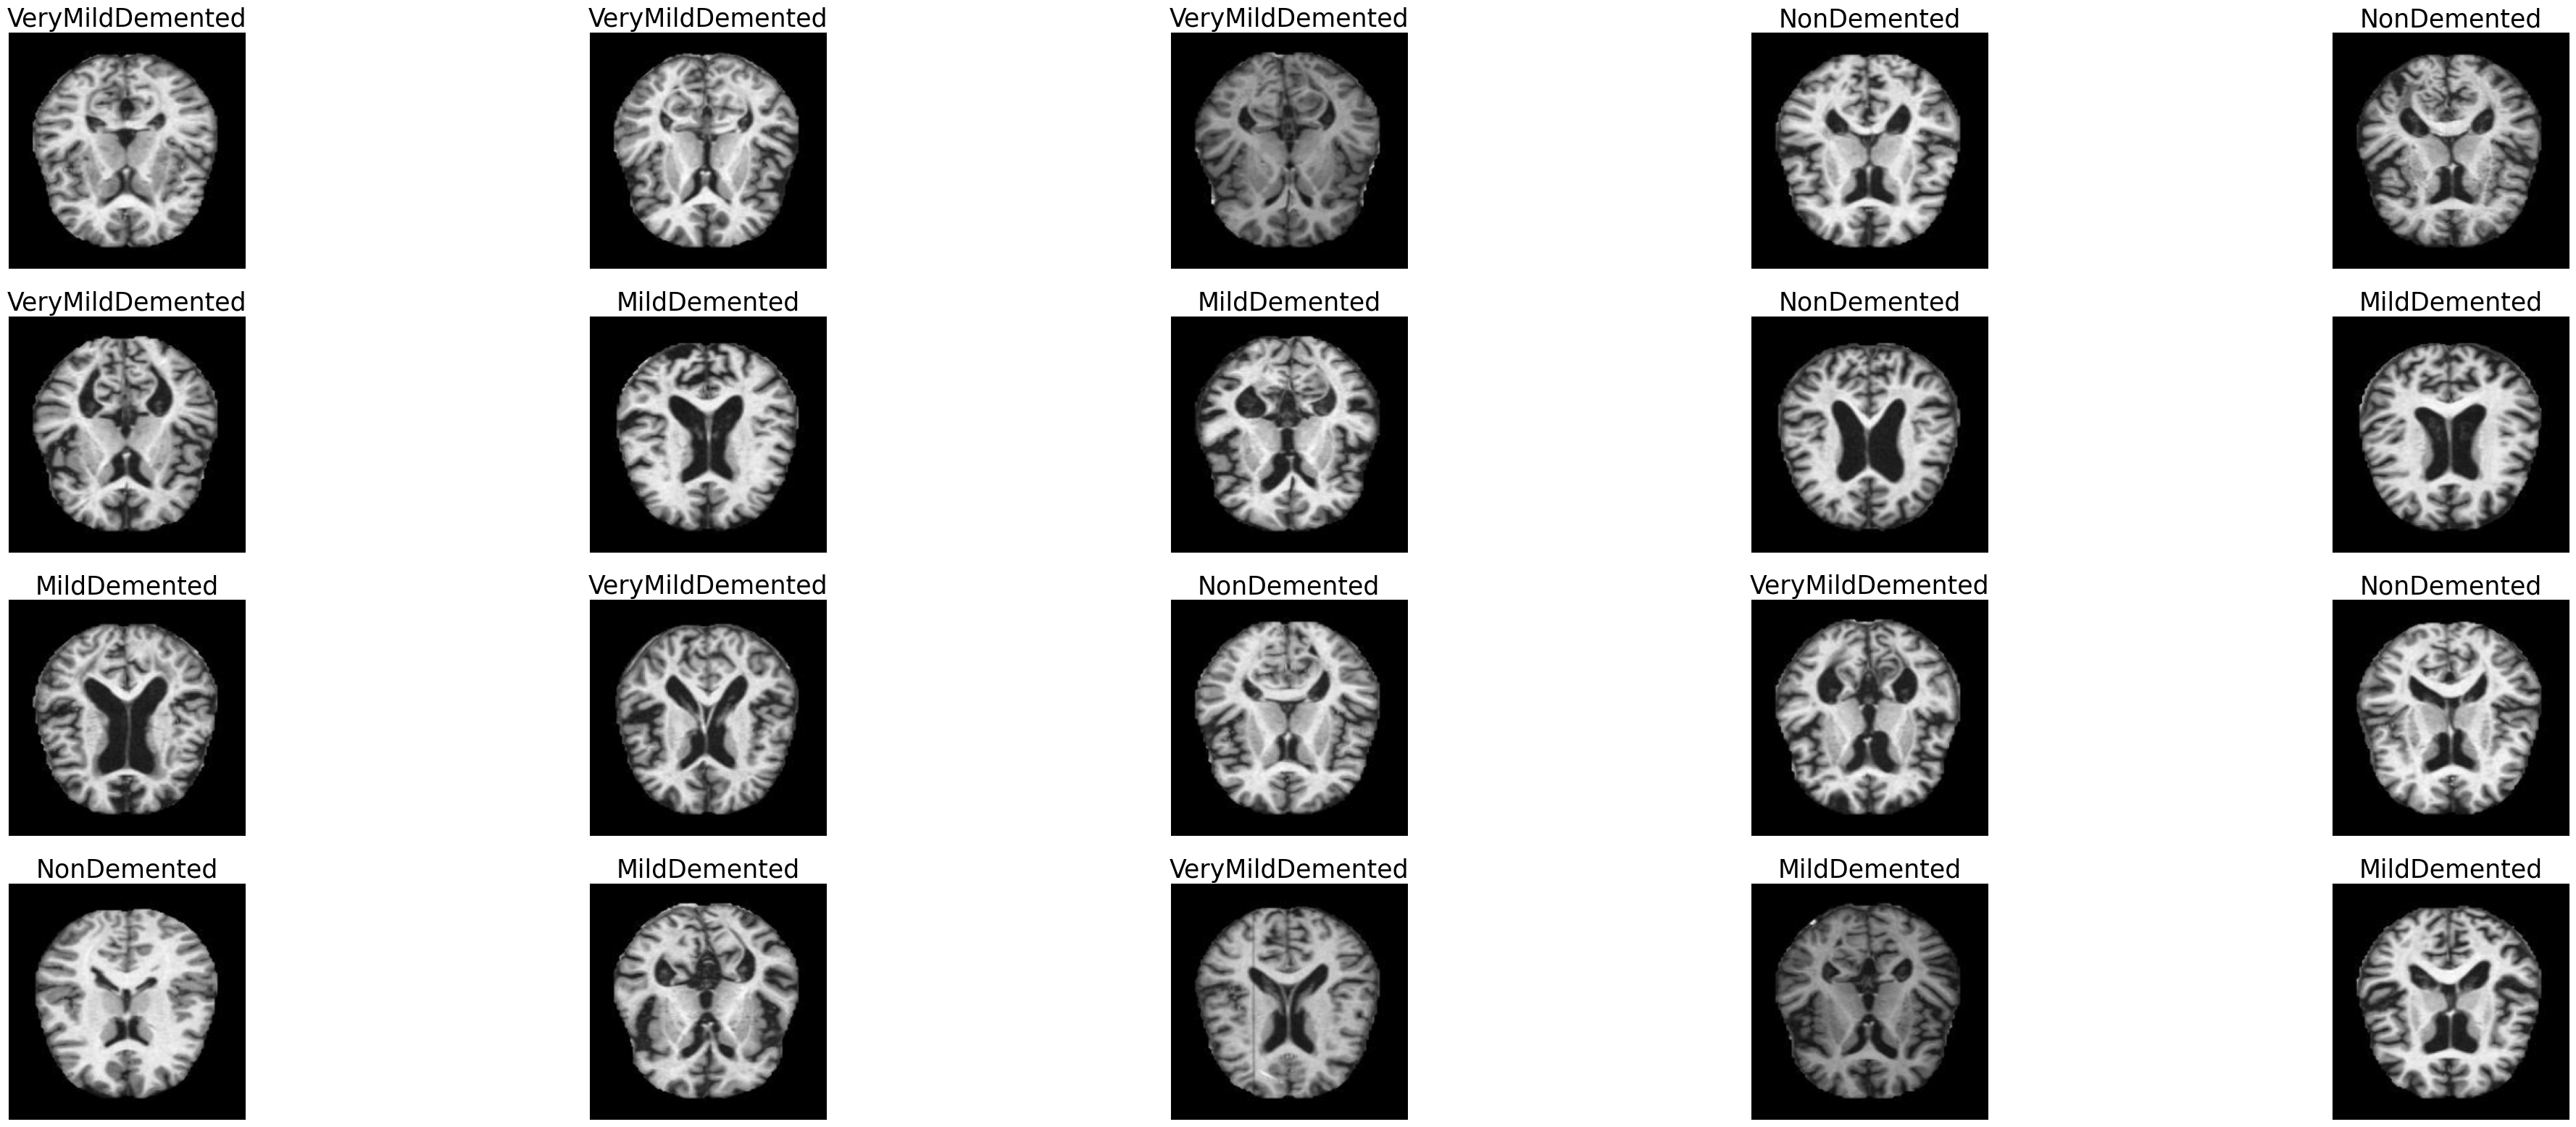

In [4]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [5]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [7]:
Size=(128,128)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 5121 validated image filenames belonging to 4 classes.


In [8]:
# Get the first batch of data and labels
train_data, train_labels = train_data_gen[0]
for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

In [9]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [10]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 128 * 128 * 3), train_labels)
train_data = train_data.reshape(-1, 128,128, 3)
print(train_data.shape, train_labels.shape)

(10240, 128, 128, 3) (10240, 4)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


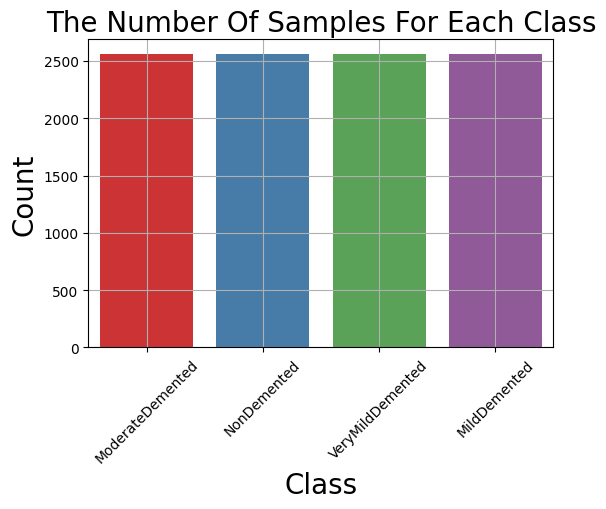

In [11]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(6,4))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [12]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (7168, 128, 128, 3)
X_test shape is  (1536, 128, 128, 3)
X_val shape is  (1536, 128, 128, 3)
y_train shape is  (7168, 4)
y_test shape is  (1536, 4)
y_val shape is  (1536, 4)


In [13]:
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D

In [14]:
from keras.models import Sequential

In [15]:
model = Sequential()

model.add(Conv2D(32,kernel_size =(2,2),input_shape = (128,128,3),padding = 'Same'))
model.add(Conv2D(32,kernel_size =(2,2),activation='relu',padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size =(2,2),activation='relu',padding = 'Same'))
model.add(Conv2D(64,kernel_size =(2,2),activation='relu',padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
          
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))
          
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adamax',metrics=['accuracy'])
          
print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,586,628 (128.12 MB)

 Trainable params: 33,586,436 (128.12 MB)

 Non-trainable params: 192 (768.00 B)

None


In [16]:
X_train.shape

(7168, 128, 128, 3)

In [17]:
X_test.shape

(1536, 128, 128, 3)

In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_data=(X_val, y_val), callbacks=callbacks)


Epoch 1/30
  7/717 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.2115 - loss: 66.5682

I0000 00:00:1719475577.033673      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719475577.054223      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4670 - loss: 9.3040

W0000 00:00:1719475597.741014      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719475599.174791      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719475600.996987      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.4671 - loss: 9.2949 - val_accuracy: 0.5202 - val_loss: 1.1767
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5998 - loss: 0.7853 - val_accuracy: 0.6719 - val_loss: 0.6777
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.6759 - loss: 0.6614 - val_accuracy: 0.8600 - val_loss: 0.4358
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7269 - loss: 0.5634 - val_accuracy: 0.8730 - val_loss: 0.3749
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7947 - loss: 0.4458 - val_accuracy: 0.9128 - val_loss: 0.3363
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8304 - loss: 0.3717 - val_accuracy: 0.9382 - val_loss: 0.2262
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8565 - loss: 0.3143 - val_accuracy: 0.9193 - val_loss: 0.2004
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8838 - loss: 0.2559 - val_accurac

In [19]:
from keras.models import load_model
model = load_model('best_model.keras')


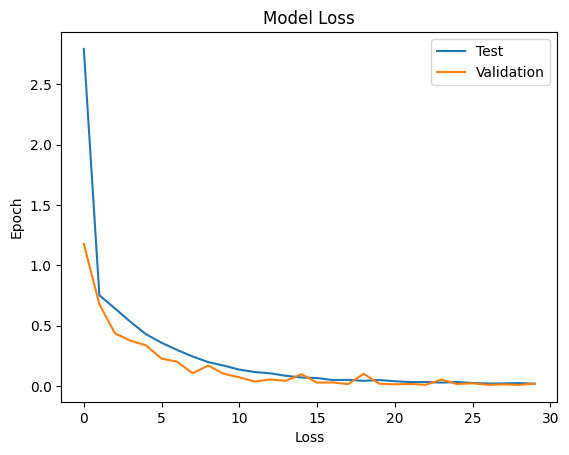

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend(['Test','Validation'],loc='upper right')
plt.show()

In [21]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

22/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9944 - loss: 0.0101

W0000 00:00:1719476066.269345      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9930 - loss: 0.0152
Test Loss = 0.02178504876792431
Test Accuracy = 0.9915364384651184


In [22]:
y_pred = np.argmax(model.predict(X_test),axis=1)
print(np.mean(y_pred == np.argmax(y_test,axis=1)))

20/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

W0000 00:00:1719476069.254909      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
0.9915364583333334


In [23]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
print("Confusion Matrix:\n", confusion_mtx)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
 [[384   0   0   0]
 [  0 384   0   0]
 [  0   0 373  11]
 [  0   0   2 382]]


In [24]:
from sklearn.metrics import f1_score

In [25]:
f1_scores = f1_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
print("F1 Score:", f1_scores)

F1 Score: 0.991535295883122


In [26]:
from sklearn.metrics import precision_score
precision_scores = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
print("Precision:", precision_scores)

Precision: 0.9916692111959288


In [27]:
from sklearn.metrics import recall_score
recall_scores = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
print("Recall:", recall_scores)

Recall: 0.9915364583333334


In [28]:
# Save the model
model_filename = 'trained_model.keras'
model.save(model_filename)
print(f'Model saved to {model_filename}')

Model saved to trained_model.keras


In [29]:
import numpy as np
if not isinstance(y_test, np.ndarray):
    y_test = np.array(y_test)

if not isinstance(y_pred, np.ndarray):
    y_pred = np.array(y_pred)

# Flatten to 1D array if necessary
if y_test.ndim > 1:
    y_test = y_test.ravel()

if y_pred.ndim > 1:
    y_pred = y_pred.ravel()

In [30]:
# Create DataFrame with actual and predicted values
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions_filename = 'predictions.csv'
predictions.to_csv(predictions_filename, index=False)
print(f'Predictions saved to {predictions_filename}')

Predictions saved to predictions.csv
